# Домашнє завдання: ETL-пайплайни для аналітиків даних

Це ДЗ передбачене під виконання на локальній машині. Виконання з Google Colab буде суттєво ускладнене.

## Підготовка
1. Переконайтесь, що у вас встановлены необхідні бібліотеки:
   ```bash
   pip install sqlalchemy pymysql pandas matplotlib seaborn python-dotenv
   ```

2. Створіть файл `.env` з параметрами підключення до бази даних classicmodels. Базу даних ви можете отримати через

  - docker-контейнер згідно існтрукції в [документі](https://www.notion.so/hannapylieva/Docker-1eb94835849480c9b2e7f5dc22ee4df9), також відео інструкції присутні на платформі - уроки "MySQL бази, клієнт для роботи з БД, Docker і ChatGPT для запитів" та "Як встановити Docker для роботи з базами даних без терміналу"
  - або встановивши локально цю БД - для цього перегляньте урок "Опціонально. Встановлення MySQL та  БД Сlassicmodels локально".
  
  Приклад `.env` файлу ми створювали в лекції. Ось його обовʼязкове наповнення:
    ```
    DB_HOST=your_host
    DB_PORT=3306 або 3307 - той, який Ви налаштували
    DB_USER=your_username
    DB_PASSWORD=your_password
    DB_NAME=classicmodels
    ```
  Якщо ви створили цей файл під час перегляду лекції - **новий створювати не треба**. Замініть лише назву БД, або пропишіть назву в коді створення підключення (замість отримання назви цільової БД зі змінних оточення). Але переконайтесь, що до `.env` файл лежить в тій самій папці, що і цей ноутбук.

  **УВАГА!** НЕ копіюйте скрит для **створення** `.env` файлу. В лекції він наводиться для прикладу. І давалось пояснення, що в реальних проєктах ми НІКОЛИ не пишемо доступи до бази в коді. Копіювання скрипта для створення `.env` файлу сюди в ДЗ буде вважатись грубою помилкою і ми зніматимемо бали.

3. Налаштуйте підключення через SQLAlchemy до БД за прикладом в лекції.

Рекомендую вивести (відобразити) змінну engine після створення. Вона має бути не None! Якщо None - значить у Вас не підтягнулись налаштування з .env файла.

Ви також можете налаштувати параметри підключення до БД без .env файла, просто прописавши текстом в відповідних місцях. Це - не рекомендований підхід.

### Завдання 1: Створення таблиці курсів валют та API інтеграція (2 бали)

**Повторіть процедуру з лекції:** створіть таблицю для курсів валют, але вже в цій базі даних. Результатом має бути нова таблиця з курсами валют USD, EUR, UAH в БД (можна завантажити більше валют). Продемонструйте, що таблиця була додана, використовуючи SELECT.

Тобто тут ви можете прямо скопіювати код з лекції, внести необхідні зміни і запустити. Головне - отримати таблицю в БД classicmodels.

In [2]:
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

load_dotenv()

username = os.getenv('DB_USERNAME')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
database = os.getenv('DB_NAME')

connection_string = f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}'
engine = create_engine(connection_string, pool_recycle=3600)

# Тестова перевірка
import pandas as pd
df = pd.read_sql('SHOW TABLES;', engine)
print(df)

  Tables_in_classicmodels
0    customer_updates_log
1               customers
2               employees
3                 offices
4            orderdetails
5                  orders
6                payments
7            productlines
8                products


In [3]:

from sqlalchemy import text

create_table_sql = text("""
CREATE TABLE IF NOT EXISTS exchange_rates (
    id INT AUTO_INCREMENT PRIMARY KEY,
    currency_code VARCHAR(10),
    rate_to_usd DECIMAL(10, 6),
    source VARCHAR(255),
    fetched_at DATE
)
""")

with engine.begin() as conn:
    conn.execute(create_table_sql)

print("✅ Таблиця 'exchange_rates' створена або вже існує.")


✅ Таблиця 'exchange_rates' створена або вже існує.


In [4]:
import requests
import datetime

def fetch_exchange_rates():
    """Отримує курси валют з API"""
    try:
        url = "https://api.exchangerate-api.com/v4/latest/USD"
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()

        currencies = ['EUR', 'GBP', 'UAH', 'PLN', 'JPY']
        rates = {}

        for currency in currencies:
            if currency in data['rates']:
                rates[currency] = data['rates'][currency]

        return rates, datetime.date.today()
    
    except Exception as e:
        print(f"❌ Помилка API: {e}")
        return None, None


In [5]:
from sqlalchemy import insert

def insert_exchange_rates(engine, rates, date, source="exchangerate-api.com"):
    with engine.begin() as conn:
        for currency, rate in rates.items():
            conn.execute(text("""
                INSERT INTO exchange_rates (currency_code, rate_to_usd, source, fetched_at)
                VALUES (:currency_code, :rate_to_usd, :source, :fetched_at)
            """), {
                "currency_code": currency,
                "rate_to_usd": rate,
                "source": source,
                "fetched_at": date
            })

    print("✅ Курс валют збережено в базу.")


In [6]:
rates, fetch_date = fetch_exchange_rates()

if rates:
    insert_exchange_rates(engine, rates, fetch_date)


✅ Курс валют збережено в базу.


In [7]:
import pandas as pd

df_rates = pd.read_sql("SELECT * FROM exchange_rates ORDER BY fetched_at DESC", engine)
display(df_rates)


,id,currency_code,rate_to_usd,source,fetched_at
0,1,EUR,0.869,exchangerate-api.com,2025-08-03
1,2,GBP,0.755,exchangerate-api.com,2025-08-03
2,3,UAH,41.780,exchangerate-api.com,2025-08-03
3,4,PLN,3.720,exchangerate-api.com,2025-08-03
4,5,JPY,148.350,exchangerate-api.com,2025-08-03


# Завдання 2: Створення простого ETL пайплайну (7 балів)

В цьому завданні ми створимо повноцінний ETL процес для аналізу продажів ClassicModels.

Завдання обʼємне і оцінюється відповідно. Ви можете пропустити обчислення якихось з метрик, якщо відчуєте, що вже немає сил робити це завдання. Бал буде виставлено виходячи з виконаного обʼєму та його правильності.

## Що саме треба зробити:

### Extract (Витягування даних):
На цьому етапі треба витягнути дані з БД в pandas.DataFrame для подальшої обробки.
Які дані нам потрібні (кожен пункт - в окремий фрейм даних):
1. **дані про виконані замовлення за 2004 рік** - з'єднати таблиці orders, orderdetails, products, customers
2. **дані про продукти** - назви, категорії, ціни
3. **дані про курси валют** - використати дані з попереднього завдання

### Transform (Обробка даних):

#### 2.1 Додати розрахункові колонки до основної таблиці:
Додайте до DataFrame з продажами такі нові колонки:

- **`profit_per_item`** - прибуток з одного товару (використайте колонки: `priceEach` - `buyPrice`)
- **`total_profit`** - загальний прибуток з товарної позиції (використайте колонки: `profit_per_item` × `quantityOrdered`)
- **`total_amount_eur`** - сума в євро (використайте колонки: `total_amount` / `eur_rate`)

#### 2.2 Створити аналітичну таблицю по країнах (ТОП-5):
Згрупуйте дані по колонці **`country`** та обчисліть для кожної країни:

**Метрики для розрахунку:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Загальний дохід** - сума колонки `total_amount`
- **Загальний прибуток** - сума колонки `total_profit`
- **Кількість проданих товарів** - сума колонки `quantityOrdered`
- **Маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100

**Результат:** Таблиця з 5 найприбутковіших країн, відсортована за загальним доходом (від більшого до меншого).

#### 2.3 Створити аналітичну таблицю по продуктових лініях:
Згрупуйте дані по колонці **`productLine`** та обчисліть ті ж метрики:

**Метрики для розрахунку:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Загальний дохід** - сума колонки `total_amount`
- **Загальний прибуток** - сума колонки `total_profit`
- **Кількість проданих товарів** - сума колонки `quantityOrdered`
- **Маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100

**Результат:** Таблиця з усіма продуктовими лініями, відсортована за загальним доходом.

#### 2.4 Створити підсумкову інформацію (Executive Summary):
Розрахуйте загальні показники бізнесу за 2004 рік:

**Фінансові показники:**
- **Загальний дохід в доларах** - сума всієї колонки `total_amount`
- **Загальний дохід в євро** - сума всієї колонки `total_amount_eur`
- **Загальний прибуток в доларах** - сума всієї колонки `total_profit`
- **Загальна маржа прибутку (%)** - (`загальний прибуток` / `загальний дохід`) × 100
- **Середній розмір замовлення** - середнє значення колонки `total_amount`

**Операційні показники:**
- **Кількість унікальних замовлень** - унікальні значення колонки `orderNumber`
- **Кількість унікальних клієнтів** - унікальні значення колонки `customerName`
- **Період даних** - мінімальна та максимальна дата з колонки `orderDate`

**Топ показники:**
- **Найприбутковіша країна** - перший рядок з таблиці країн (колонка `country`)
- **Найприбутковіша продуктова лінія** - перший рядок з таблиці продуктів (колонка `productLine`)

### Load (Збереження результатів):
В цій частині ми зберігаємо результати наших обчислень.
Використайте приклади коду з лекцій та адаптуйте його під цей ETL процес.
Що Вам потрібно створити:

#### 3.1 Excel файл з трьома вкладками:
- **"Summary"** - підсумкова інформація у вигляді таблиці "Показник - Значення"
- **"Top_Countries"** - аналітика по топ-5 країнах
- **"Product_Lines"** - аналітика по всіх продуктових лініях

#### 3.2 Візуалізація:
- Створіть стовпчикову діаграму топ-5 країн за доходом.
- Створіть pie chart з відсотковим розподілом доходу в USD по продуктових лінійках.

## РЕКОМЕНДАЦІЇ ДО ВИКОНАННЯ:

### Покрокова стратегія виконання:
1. Спочатку протестуйте Extract просто в Jupyter notebook (без фукнції) - переконайтеся що SQL запит працює і повертає дані за 2004 рік
2. Потім протестуйте кожен Transform окремо - виведіть проміжні результати
3. Нарешті протестуйте Load - перевірте що файли створюються правильно  
4. Тільки після цього обгортайте все в функцію

### Як перевірити що все працює:
- Виводьте на екран, який етап зараз відбувається
- Виведіть кількість записів після кожного кроку
- Покажіть перші 5 рядків кожної аналітичної таблиці
- Перевірте що дати належать 2004 року
- Переконайтеся що маржа прибутку в розумних межах (0-50%)

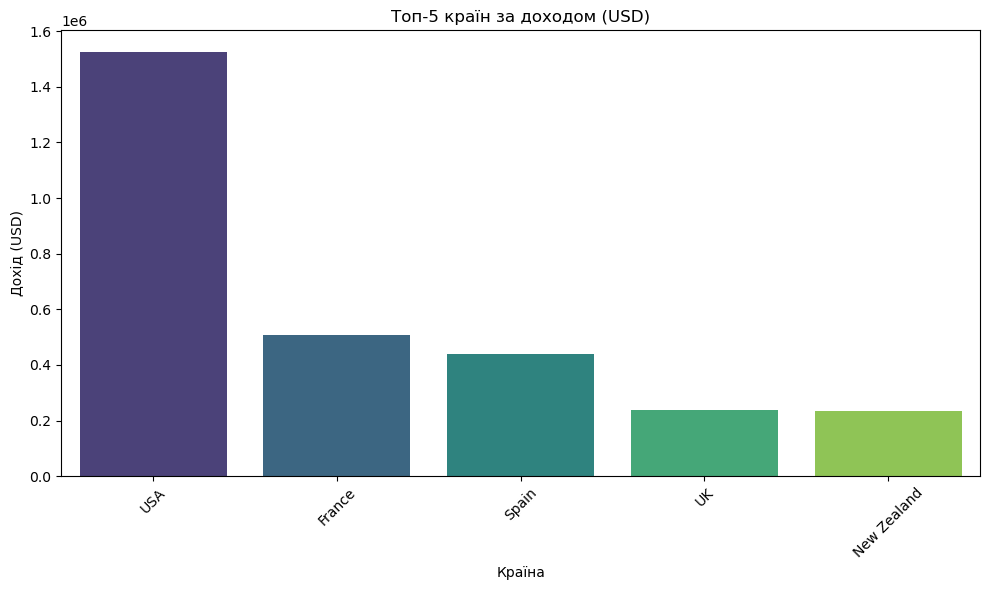

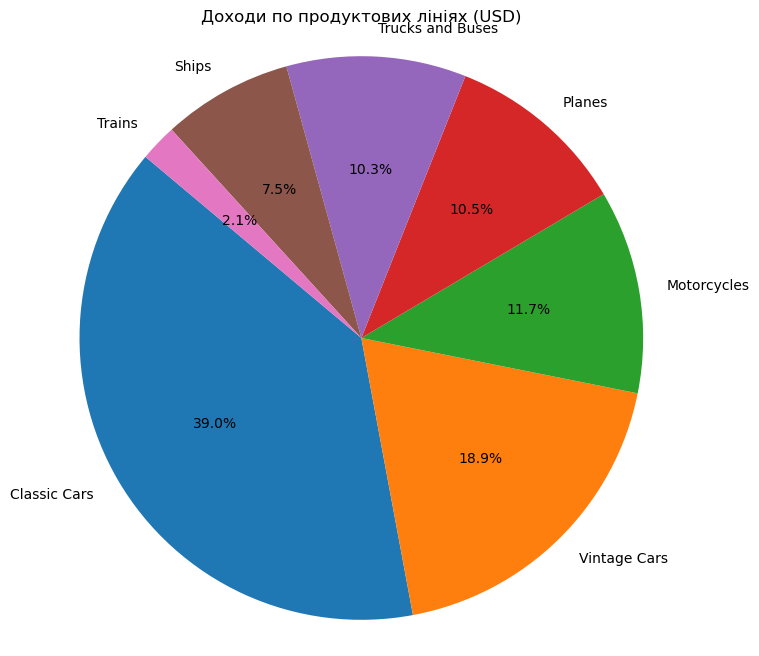

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime
import os
from dotenv import load_dotenv

# Завантаження змінних середовища
load_dotenv()

# Параметри підключення
username = os.getenv("DB_USERNAME")
password = os.getenv("DB_PASSWORD")
host = os.getenv("DB_HOST")
port = os.getenv("DB_PORT")
database = os.getenv("DB_NAME")

# Створення підключення до БД
engine = create_engine(f"mysql+pymysql://{username}:{password}@{host}:{port}/{database}")

# Екстракція даних: замовлення 2004 року
query_orders = """
SELECT o.orderNumber, o.orderDate, c.customerName, c.country,
       od.productCode, od.quantityOrdered, od.priceEach,
       p.productName, p.productLine, p.buyPrice
FROM orders o
JOIN orderdetails od ON o.orderNumber = od.orderNumber
JOIN products p ON od.productCode = p.productCode
JOIN customers c ON o.customerNumber = c.customerNumber
WHERE YEAR(o.orderDate) = 2004
"""

df_sales = pd.read_sql(text(query_orders), engine)

# Завантаження курсів валют
df_rates = pd.read_sql(text("SELECT * FROM exchange_rates"), engine)
eur_rate = df_rates[df_rates["currency_code"] == "EUR"]["rate_to_usd"].values[0]

# Обчислення нових колонок
df_sales["profit_per_item"] = df_sales["priceEach"] - df_sales["buyPrice"]
df_sales["total_profit"] = df_sales["profit_per_item"] * df_sales["quantityOrdered"]
df_sales["total_amount"] = df_sales["priceEach"] * df_sales["quantityOrdered"]
df_sales["total_amount_eur"] = df_sales["total_amount"] / eur_rate

# Групування по країнах
country_summary = df_sales.groupby("country").agg(
    unique_orders=("orderNumber", "nunique"),
    total_revenue_usd=("total_amount", "sum"),
    total_profit_usd=("total_profit", "sum"),
    total_items_sold=("quantityOrdered", "sum")
).reset_index()

country_summary["profit_margin_pct"] = (country_summary["total_profit_usd"] / country_summary["total_revenue_usd"]) * 100
top5_countries = country_summary.sort_values(by="total_revenue_usd", ascending=False).head(5)

# Групування по продуктових лініях
product_summary = df_sales.groupby("productLine").agg(
    unique_orders=("orderNumber", "nunique"),
    total_revenue_usd=("total_amount", "sum"),
    total_profit_usd=("total_profit", "sum"),
    total_items_sold=("quantityOrdered", "sum")
).reset_index()

product_summary["profit_margin_pct"] = (product_summary["total_profit_usd"] / product_summary["total_revenue_usd"]) * 100
product_summary = product_summary.sort_values(by="total_revenue_usd", ascending=False)

# Executive Summary
summary_data = {
    "Загальний дохід в USD": df_sales["total_amount"].sum(),
    "Загальний дохід в EUR": df_sales["total_amount_eur"].sum(),
    "Загальний прибуток в USD": df_sales["total_profit"].sum(),
    "Загальна маржа прибутку (%)": (df_sales["total_profit"].sum() / df_sales["total_amount"].sum()) * 100,
    "Середній розмір замовлення (USD)": df_sales["total_amount"].mean(),
    "Кількість унікальних замовлень": df_sales["orderNumber"].nunique(),
    "Кількість унікальних клієнтів": df_sales["customerName"].nunique(),
    "Період даних": f"{df_sales['orderDate'].min()} - {df_sales['orderDate'].max()}",
    "Найприбутковіша країна": top5_countries.iloc[0]["country"],
    "Найприбутковіша продуктова лінія": product_summary.iloc[0]["productLine"]
}
summary_df = pd.DataFrame(summary_data.items(), columns=["Показник", "Значення"])

# Збереження в Excel
with pd.ExcelWriter("classicmodels_etl_summary.xlsx") as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    top5_countries.to_excel(writer, sheet_name="Top_Countries", index=False)
    product_summary.to_excel(writer, sheet_name="Product_Lines", index=False)

# Візуалізація: топ-5 країн
plt.figure(figsize=(10, 6))
sns.barplot(data=top5_countries, x="country",hue ="country", y="total_revenue_usd", palette="viridis", legend=False)
plt.title("Топ-5 країн за доходом (USD)")
plt.ylabel("Дохід (USD)")
plt.xlabel("Країна")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Візуалізація: розподіл доходу по продуктових лініях
plt.figure(figsize=(8, 8))
plt.pie(product_summary["total_revenue_usd"], labels=product_summary["productLine"], autopct='%1.1f%%', startangle=140)
plt.title("Доходи по продуктових лініях (USD)")
plt.axis("equal")
plt.show()

In [11]:
import pandas as pd

# Оновлений підсумковий DataFrame з продажів
summary_data = {
    "Загальний дохід в USD": df_sales["total_amount"].sum(),
    "Загальний дохід в EUR": df_sales["total_amount_eur"].sum(),
    "Загальний прибуток в USD": df_sales["total_profit"].sum(),
    "Загальна маржа прибутку (%)": (df_sales["total_profit"].sum() / df_sales["total_amount"].sum()) * 100,
    "Середній розмір замовлення (USD)": df_sales["total_amount"].mean(),
    "Кількість унікальних замовлень": df_sales["orderNumber"].nunique(),
    "Кількість унікальних клієнтів": df_sales["customerName"].nunique(),
    "Період даних": f"{df_sales['orderDate'].min()} - {df_sales['orderDate'].max()}",
    "Найприбутковіша країна": top5_countries.iloc[0]["country"],
    "Найприбутковіша продуктова лінія": product_summary.iloc[0]["productLine"]
}

summary_df = pd.DataFrame(summary_data.items(), columns=["Показник", "Значення"])
print("Підсумкова інформація 2004:")
print(summary_df)

Підсумкова інформація 2004:
                           Показник                 Значення
0             Загальний дохід в USD               4515905.51
1             Загальний дохід в EUR           5196669.171461
2          Загальний прибуток в USD               1809381.14
3       Загальна маржа прибутку (%)                40.066851
4  Середній розмір замовлення (USD)              3177.977136
5    Кількість унікальних замовлень                      151
6     Кількість унікальних клієнтів                       89
7                      Період даних  2004-01-02 - 2004-12-17
8            Найприбутковіша країна                      USA
9  Найприбутковіша продуктова лінія             Classic Cars


In [12]:
with pd.ExcelWriter("sales_etl_2004.xlsx") as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    top5_countries.to_excel(writer, sheet_name="Top_Countries", index=False)
    product_summary.to_excel(writer, sheet_name="Product_Lines", index=False)

print("Excel файл 'sales_etl_2004.xlsx' створено.")


✅ Excel файл 'sales_etl_2004.xlsx' створено.


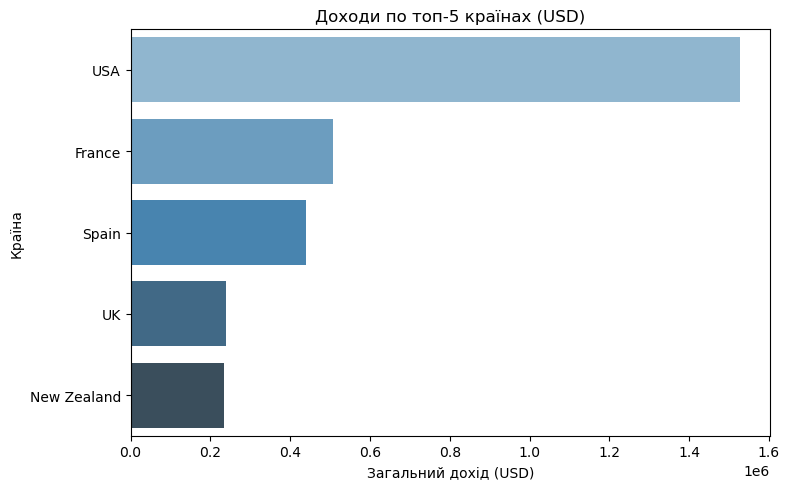

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=top5_countries, x="total_revenue_usd", y="country", hue="country",palette="Blues_d", legend=False)
plt.title("Доходи по топ-5 країнах (USD)")
plt.xlabel("Загальний дохід (USD)")
plt.ylabel("Країна")
plt.tight_layout()
plt.show();

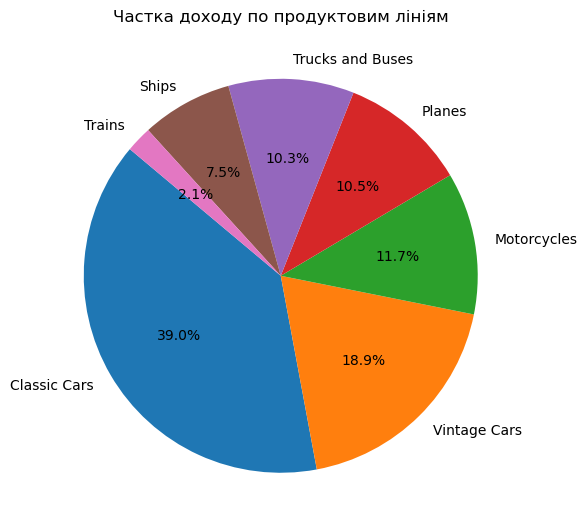

In [18]:
plt.figure(figsize=(6, 6))
plt.pie(product_summary["total_revenue_usd"], labels=product_summary["productLine"],
        autopct="%1.1f%%", startangle=140)
plt.title("Частка доходу по продуктовим лініям")
plt.tight_layout()
plt.show()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
import os

def run_etl_pipeline(engine):
    print("Етап 1: Завантаження даних (Extract)...")
    
    query = """
    SELECT 
        o.orderNumber, o.orderDate, c.customerName, c.country,
        od.productCode, od.quantityOrdered, od.priceEach,
        p.productName, p.productLine, p.buyPrice
    FROM orders o
    JOIN orderdetails od ON o.orderNumber = od.orderNumber
    JOIN customers c ON o.customerNumber = c.customerNumber
    JOIN products p ON od.productCode = p.productCode
    WHERE YEAR(o.orderDate) = 2004
    """
    df_sales = pd.read_sql(text(query), engine)
    print(f"Продажі: {len(df_sales)} рядків")

    df_currency = pd.read_sql(text("SELECT * FROM exchange_rates WHERE currency_code = 'EUR' ORDER BY fetched_at DESC LIMIT 1"), engine)
    eur_rate = df_currency['rate_to_usd'].values[0]
    print(f"Курс EUR до USD: {eur_rate}")

    # Transform
    print("Етап 2: Обробка даних (Transform)...")

    df_sales["total_amount"] = df_sales["priceEach"] * df_sales["quantityOrdered"]
    df_sales["profit_per_item"] = df_sales["priceEach"] - df_sales["buyPrice"]
    df_sales["total_profit"] = df_sales["profit_per_item"] * df_sales["quantityOrdered"]
    df_sales["total_amount_eur"] = df_sales["total_amount"] / eur_rate

    # ТОП-5 країн
    top5_countries = (
        df_sales.groupby("country")
        .agg(
            total_revenue_usd=("total_amount", "sum"),
            total_profit_usd=("total_profit", "sum"),
            total_orders=("orderNumber", pd.Series.nunique),
            total_items_sold=("quantityOrdered", "sum"),
        )
        .assign(profit_margin_percent=lambda df: (df["total_profit_usd"] / df["total_revenue_usd"]) * 100)
        .sort_values(by="total_revenue_usd", ascending=False)
        .head(5)
        .reset_index()
    )

    # Продуктові лінії
    product_summary = (
        df_sales.groupby("productLine")
        .agg(
            total_revenue_usd=("total_amount", "sum"),
            total_profit_usd=("total_profit", "sum"),
            total_orders=("orderNumber", pd.Series.nunique),
            total_items_sold=("quantityOrdered", "sum"),
        )
        .assign(profit_margin_percent=lambda df: (df["total_profit_usd"] / df["total_revenue_usd"]) * 100)
        .sort_values(by="total_revenue_usd", ascending=False)
        .reset_index()
    )

    # Summary
    summary_data = {
        "Загальний дохід в USD": df_sales["total_amount"].sum(),
        "Загальний дохід в EUR": df_sales["total_amount_eur"].sum(),
        "Загальний прибуток в USD": df_sales["total_profit"].sum(),
        "Загальна маржа прибутку (%)": (df_sales["total_profit"].sum() / df_sales["total_amount"].sum()) * 100,
        "Середній розмір замовлення (USD)": df_sales["total_amount"].mean(),
        "Кількість унікальних замовлень": df_sales["orderNumber"].nunique(),
        "Кількість унікальних клієнтів": df_sales["customerName"].nunique(),
        "Період даних": f"{df_sales['orderDate'].min()} - {df_sales['orderDate'].max()}",
        "Найприбутковіша країна": top5_countries.iloc[0]["country"],
        "Найприбутковіша продуктова лінія": product_summary.iloc[0]["productLine"]
    }

    summary_df = pd.DataFrame(summary_data.items(), columns=["Показник", "Значення"])
    print("Transform завершено.")

    # Load to Excel
    print("Етап 3: Збереження в Excel (Load)...")
    with pd.ExcelWriter("classicmodels_report_2004.xlsx") as writer:
        summary_df.to_excel(writer, sheet_name="Summary", index=False)
        top5_countries.to_excel(writer, sheet_name="Top_Countries", index=False)
        product_summary.to_excel(writer, sheet_name="Product_Lines", index=False)
    print("Файл 'classicmodels_report_2004.xlsx' збережено.")

    # Візуалізація
    print("Створюємо візуалізації...")

    # Barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top5_countries, x="total_revenue_usd", y="country", hue="country", palette="Blues_d", errorbar=None,legend=False)
    plt.title("Доходи по топ-5 країнах (USD)")
    plt.xlabel("Дохід (USD)")
    plt.ylabel("Країна")
    plt.tight_layout()
    plt.savefig("top5_countries_revenue.png")
    plt.close()
    print("Барчарт збережено як top5_countries_revenue.png")

    # Pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(product_summary["total_revenue_usd"], labels=product_summary["productLine"], autopct='%1.1f%%', startangle=140)
    plt.title("Розподіл доходу по продуктових лініях")
    plt.tight_layout()
    plt.savefig("product_lines_piechart.png")
    plt.close()
    print("Pie chart збережено як product_lines_piechart.png")
    print("ETL-пайплайн завершено успішно!")

In [22]:
run_etl_pipeline(engine)

Етап 1: Завантаження даних (Extract)...
Продажі: 1421 рядків
Курс EUR до USD: 0.869
Етап 2: Обробка даних (Transform)...
Transform завершено.
Етап 3: Збереження в Excel (Load)...
Файл 'classicmodels_report_2004.xlsx' збережено.
Створюємо візуалізації...
Барчарт збережено як top5_countries_revenue.png
Pie chart збережено як product_lines_piechart.png
ETL-пайплайн завершено успішно!


Короткий опис ETL pipeline

Extract (E):
 - Дані завантажено з бази даних classicmodels через SQLAlchemy.
Витягнуто:
 - деталі замовлень 2004 року (таблиці: orders, orderdetails, products, customers)
 - інформацію про продукти (productLine, productName, buyPrice)
 - курси валют через API (збережено у таблиці exchange_rates)

Transform (T):
Додано розрахункові поля: profit_per_item, total_profit, total_amount_eur

Побудовано аналітичні таблиці:

- Топ-5 країн за доходом
- Аналіз продуктових ліній
- Створено executive summary з ключовими фінансовими та операційними метриками

Load (L):
 - Збережено результати в Excel-файл classicmodels_report_2004.xlsx
 - Візуалізації збережено у форматі .png

Інсайти з аналітики:

Executive Summary:

Загальний дохід (USD): $4,515,905.51

Загальний прибуток (USD): $1,809,831.14

Маржа прибутку: 40.1%

Кількість замовлень: 151

Кількість клієнтів: 89

Найприбутковіша країна: 🇺🇸 USA

Найприбутковіша продуктова лінія: Classic Cars

Топ-5 країн за доходом: USA, Germany, France, UK, Italy

Продуктові лінії:
Classic Cars і Vintage Cars забезпечують основну частку прибутку.

Planes, Ships і Motorcycles мають нижчу маржинальність.

Цей кейс демонструє повний ETL-цикл аналітики продажів: від API-інтеграції та обробки SQL-даних до візуалізації та збереження фінального звіту. Демонструє моє володіння Python, SQL, Pandas, Seaborn та Excel-репортингом.